In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import itertools
from typing import Iterable
from qutip import Qobj
def trajectory_min_eigs(rhos: Iterable[Qobj]) -> np.ndarray:
    """Vector of minimal eigenvalues over a trajectory."""
    return np.array([rho.eigenenergies().min() for rho in rhos], dtype=float)


from qspectro2d.spectroscopy import compute_spectra
from qspectro2d.visualization import plot_example_evo, plot_el_field, plot_e_pulses
from qspectro2d.spectroscopy.e_field_1d import compute_polarization_over_window, compute_evolution, sim_with_only_pulses
from qspectro2d.utils import phase_cycle_component
from qspectro2d.utils.rwa_utils import get_expect_vals_with_RWA
from qspectro2d.config import create_base_sim_oqs

from plotstyle import init_style, COLORS
init_style()

from pathlib import Path
custom_dir = Path("test_Spectroscopy")
custom_dir.mkdir(exist_ok=True)

In [2]:
# Build base simulation (applies CLI overrides inside)
from pathlib import Path
NOTEBOOK_DIR = Path.cwd()
for _parent in NOTEBOOK_DIR.parents:
    if (_parent / ".git").is_dir():
        PROJECT_ROOT = _parent
        break
SCRIPTS_DIR = (PROJECT_ROOT / "scripts").resolve()
config_path = SCRIPTS_DIR / "simulation_configs" / "_dimer_uncoupled.yaml"
sim_oqs, time_cut = create_base_sim_oqs(config_path=str(config_path))

🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...

 
=== SOLVER DIAGNOSTICS ===
Solver: BR
Time range: t0=-39.500, t_max=2.000, dt=0.100000
Number of time points: 416
RWA enabled: True

 
=== SYSTEM DIAGNOSTICS ===
Initial state type, shape, is hermitian, trace: <class 'qutip.core.qobj.Qobj'>, (4, 4), True, 1.000000
Initial eigenvalues range: [0.000000, 1.000000]
Initial min eigenvalue: 0.0000000000
Total Hamiltonian dims: [[[4], [4]], [[4], [4]]]
Total Hamiltonian type: <class 'qutip.core.cy.qobjevo.QobjEvo'>
Number of decay channels: 4

 
=== STATE-BY-STATE ANALYSIS ===
✅ Checks passed. DM remains Hermitian and positive.
Final state trace: 1.000000
Final state min eigenvalue: 0.0431666670
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)


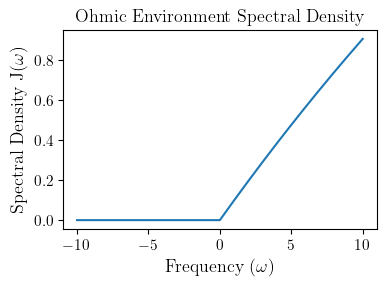

In [3]:
import numpy as np

sim_oqs.decay_channels
import matplotlib.pyplot as plt

# Define frequency range for plotting (adjust as needed)
omega = np.linspace(-10, 10, 1000)  # in units consistent with sim_oqs.bath

# Compute spectral density
J = [sim_oqs.bath.spectral_density(w) for w in omega]

# Plot
plt.figure(figsize=(4, 3))
plt.plot(omega, J)
plt.xlabel('Frequency ($\omega$)')
plt.ylabel('Spectral Density J($\omega$)')
plt.title('Ohmic Environment Spectral Density')
plt.show()

Text(0.5, 1.0, 'Minimal eigenvalue (positivity check)')

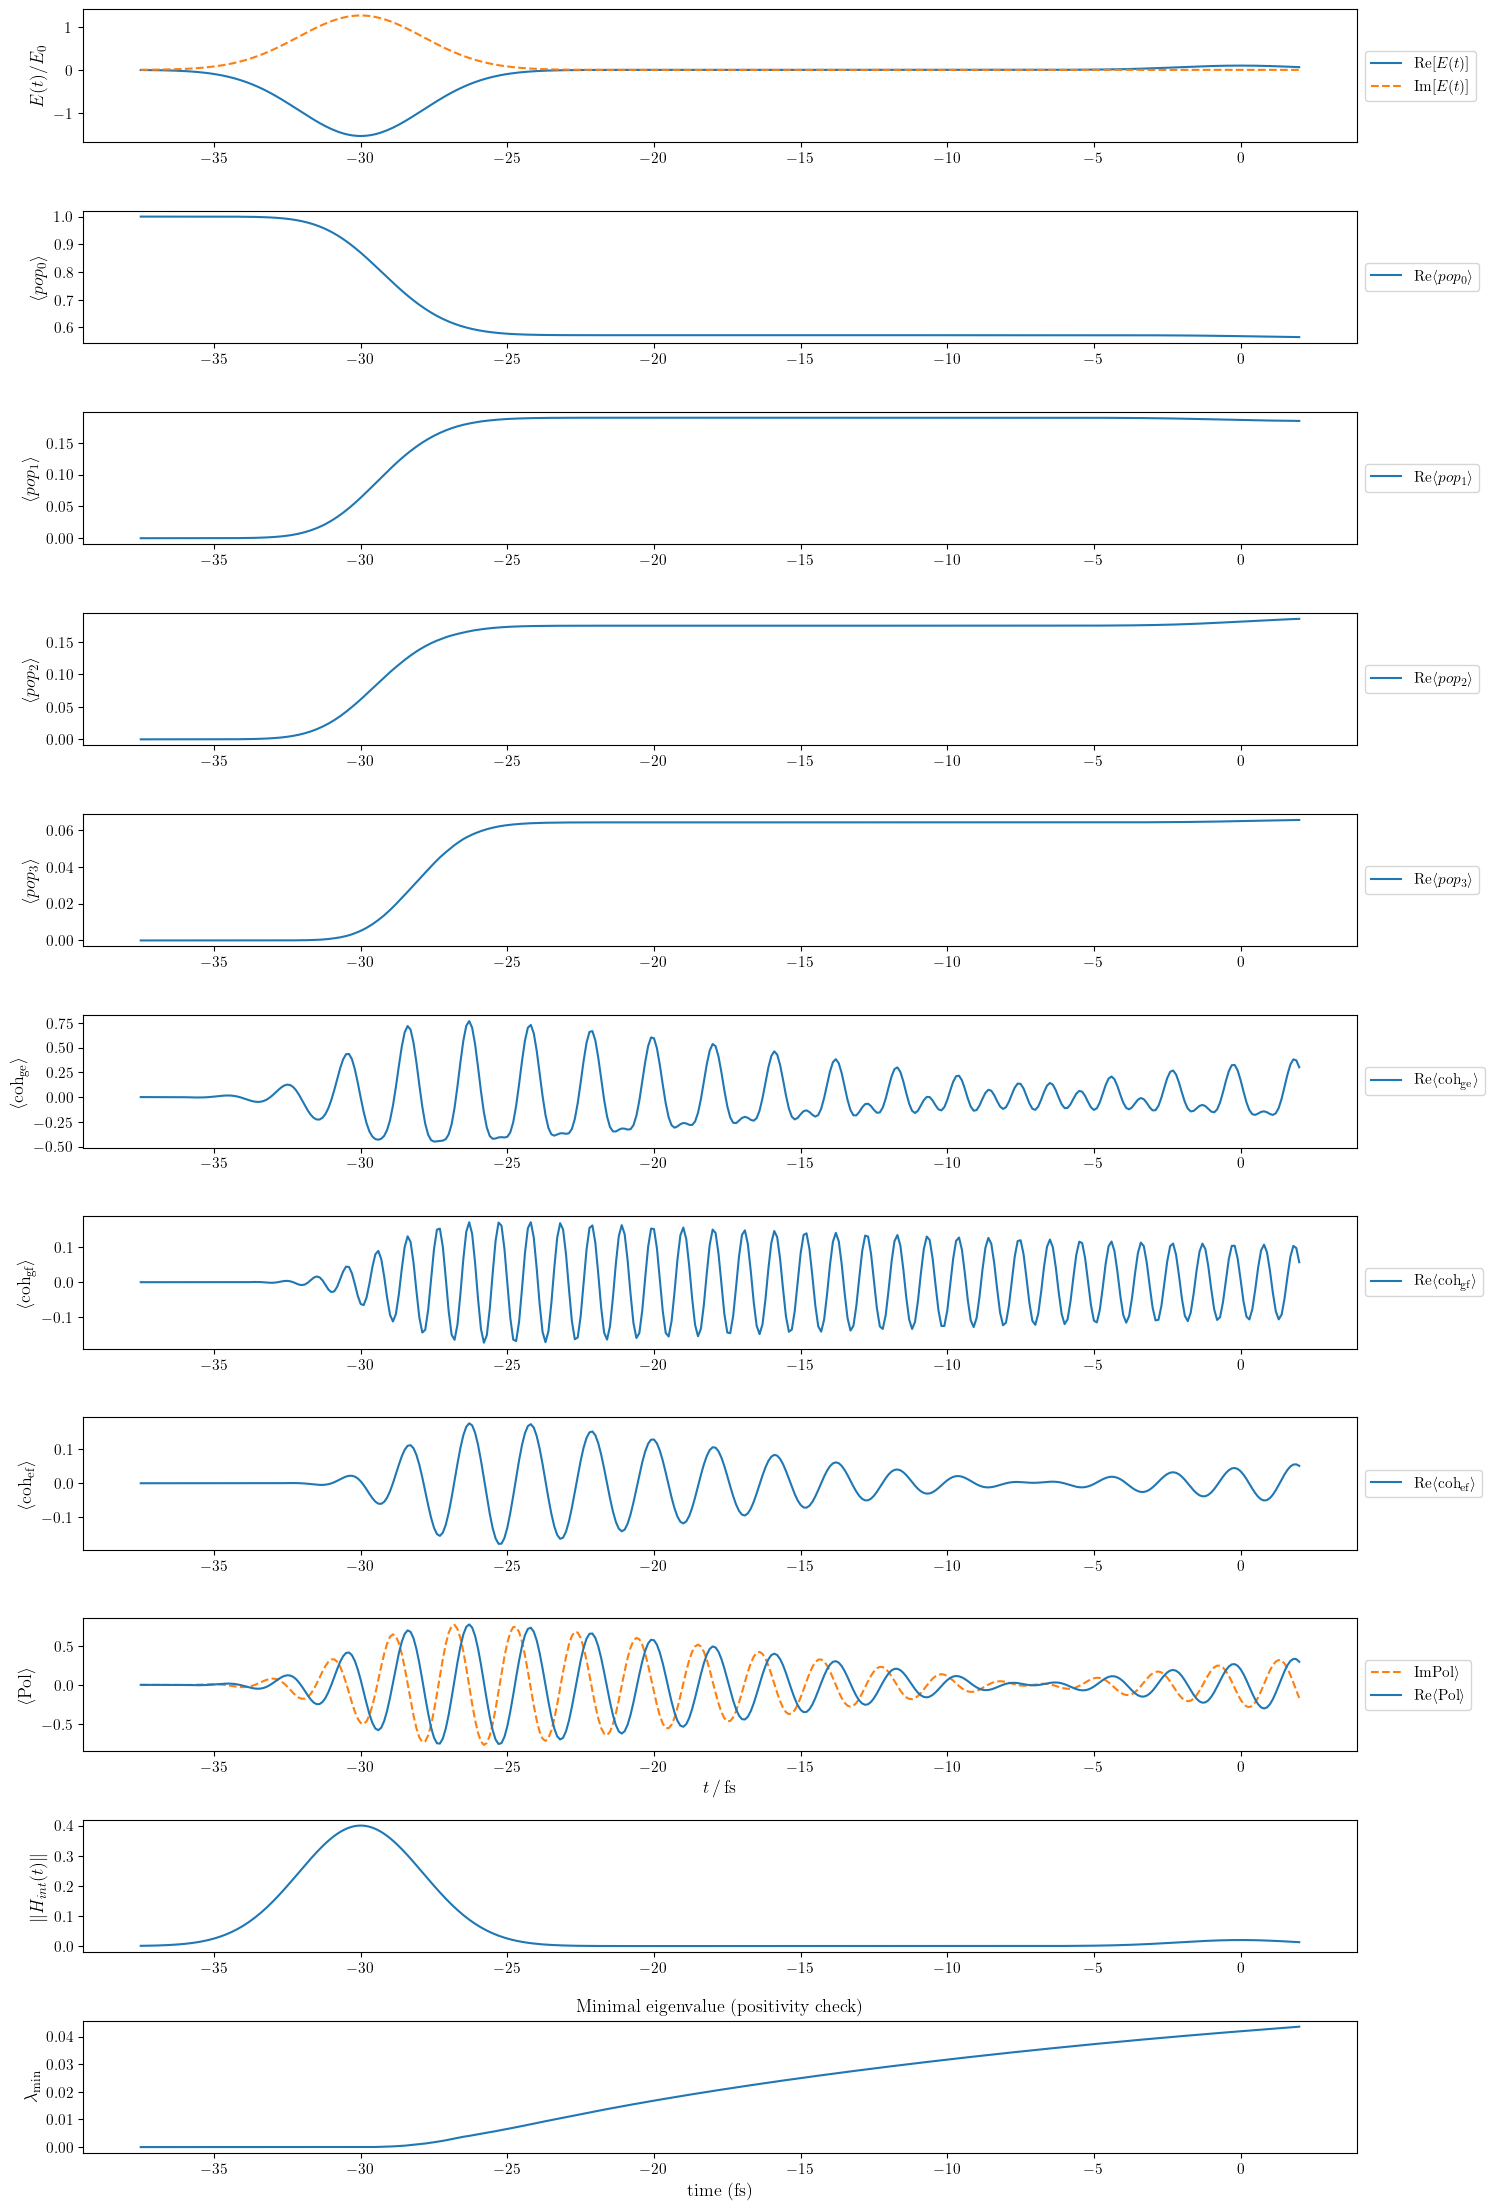

In [4]:
# Build an explicit copy (same pulses in this case)
sim_i = sim_with_only_pulses(sim_oqs, [0, 1, 2])
sim_i.update_delays(t_coh=0.0)

times, det_states = compute_evolution(sim_i)
rwa_sl = sim_i.simulation_config.rwa_sl

# Compute expectation values; pass dipole in the same basis as evolution (eigenbasis)
dipole_op_eig = sim_i.system.to_eigenbasis(sim_i.system.dipole_op)
expectation_values = get_expect_vals_with_RWA(
    det_states,
    times,
    sim_i.system.n_atoms,
    sim_i.observable_ops,
    sim_i.laser.carrier_freq_fs,
    rwa_sl=rwa_sl,
    dipole_op=dipole_op_eig,
)

# Generalize for any N_atoms
n_obs = len(expectation_values)
nrows = n_obs + 3
fig, axes = plt.subplots(nrows, 1, figsize=(15, 2 * nrows))
fig_evo = plot_example_evo(
    times,
    expectation_values,
    sim_i.laser,
    rwa_sl=rwa_sl,
    observable_strs=sim_i.observable_strs,
    ax=axes[:n_obs + 1]
)
norms_all = np.array([sim_i.H_int_sl(t).norm() for t in times])

axes[n_obs + 1].plot(times, norms_all)
axes[n_obs + 1].set_ylabel(r"$\|H_{int}(t)\|$")

min_eigs = trajectory_min_eigs(det_states)
axes[n_obs + 2].plot(times, min_eigs)
axes[n_obs + 2].set_ylabel(r'$\lambda_{\min}$')
axes[n_obs + 2].set_xlabel('time (fs)')
axes[n_obs + 2].set_title('Minimal eigenvalue (positivity check)')

In [5]:
import numpy as np
L = sim_i.evo_obj
t = 0.0

eigvals = L(t).eigenenergies()
rates = np.abs(np.real(eigvals))
eps = 1e-14  # ignore exact zeros and numerical dust
nz = rates[rates > eps]
R = nz.max() / nz.min()
print("stiffness ratio =", R)

rates = np.real(eigvals)
ratio = abs(np.max(rates)) / max(abs(np.min(rates)), 1e-16)
print("Largest |Re(λ)|:", np.max(abs(rates)))
print("Smallest nonzero |Re(λ)|:", np.min(abs(rates[np.nonzero(rates)])))
print("Ratio:", ratio)


stiffness ratio = 113.98425175642855
Largest |Re(λ)|: 0.02984462428736163
Smallest nonzero |Re(λ)|: 1.8205020612122365e-18
Ratio: 6.099932918181076e-17


# Workflow: `parallel_compute_1d_e_comps`

Super-short stepped visualization added below:
1. Inspect and plot laser pulses (envelope, RWA field, full field).
2. Run several evolutions with different active pulse subsets / modified parameters.
3. Plot expectation values + polarization for multiple detection sub-windows.
4. Build raw phase grid `P_{phi1,phi2}(t)` and extract a phase-cycled component.
5. (Mini 2D) Sweep a few coherence delays `t_coh` to assemble a tiny 2D block and phase-cycle each slice.

Each subsequent cell implements one step.


In [6]:
# Helper functions: polarization + phase-cycling pieces
from qspectro2d.core.simulation.time_axes import compute_t_det, compute_times_local, compute_t_coh

def build_phase_grid(sim, phases):
    P_grid = []
    t_actual = None
    t_det = compute_t_det(sim.simulation_config)
    for phi1 in phases:
        row = []
        for phi2 in phases:
            sim_w = deepcopy(sim)
            sim_w.laser.pulse_phases = [phi1, phi2]
            t_actual, P_total = compute_polarization_over_window(sim_w, t_det)
            # Subtract signals from all subsets of size 1 pulses active
            P_sub_sum = np.zeros_like(P_total, dtype=np.complex128)
            n_pulses = len(sim_w.laser.pulses)
            for k in range(1, 2):  # subsets of size 1
                for combo in itertools.combinations(range(n_pulses), k):
                    sim_sub = sim_with_only_pulses(sim_w, list(combo))
                    _, P_sub = compute_polarization_over_window(sim_sub, t_actual)
                    P_sub_sum += P_sub

            P_phi = P_total - P_sub_sum
            row.append(P_phi)
        P_grid.append(row)
    return t_actual, np.array(P_grid)  # shape (n,n,t)

Base window: -39.5 2.0 416
[np.float64(-32.0), np.float64(-30.0), np.float64(0.0)]


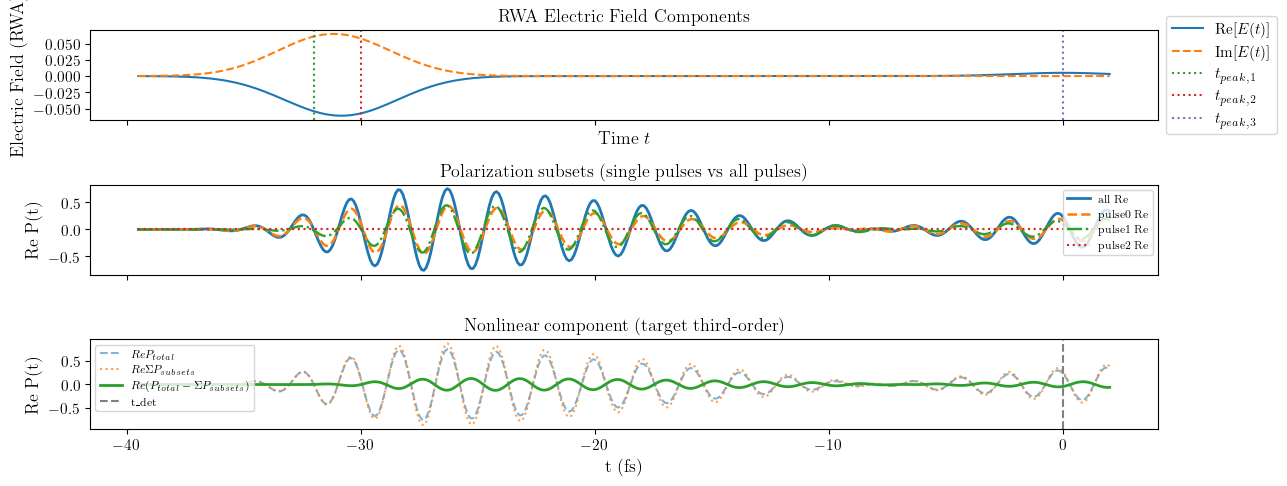

In [7]:
# 2. Evolution subsets: all pulses vs single pulse vs modified amplitude
subset_specs = {}

# Add all pulses
subset_specs['all'] = list(range(len(sim_oqs.laser.pulses)))

# Add individual pulses
for i in range(len(sim_oqs.laser.pulses)):
    subset_specs[f'pulse{i}'] = [i]

pol_datas = {}
base_window = compute_times_local(sim_oqs.simulation_config)
print("Base window:", base_window[0], base_window[-1], len(base_window))
# Compute polarization for each subset
for label, pulse_indices in subset_specs.items():
    if label == 'all':
        # Use the full simulation for all pulses
        sim_sub = sim_oqs
    else:
        # Use only the specified pulse(s)
        sim_sub = sim_with_only_pulses(sim_oqs, pulse_indices)

    t_actual, P = compute_polarization_over_window(sim_sub, base_window)
    pol_datas[label] = P

# Build nonlinear component: P_total - Σ_{subsets of size 1} P_subset
P_total = pol_datas['all']
P_linear_sum = sum(P for label, P in pol_datas.items() if label != 'all')
P_nonlinear = P_total - P_linear_sum

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(13,5), sharex=True)
ax0, ax1, ax2 = axes

ax0 = plot_e_pulses(base_window, sim_oqs.laser, ax=ax0)
print(sim_oqs.laser.pulse_peak_times)
# Subplot 1: subset comparison (real part)
for idx, (k, v) in enumerate(pol_datas.items()):
    ax1.plot(t_actual, np.real(v), color=COLORS[idx % len(COLORS)],
             linewidth=2-0.15*idx, label=f'{k} Re')
ax1.set_ylabel('Re P(t)')
ax1.set_title('Polarization subsets (single pulses vs all pulses)')
ax1.legend(loc='best', fontsize=8)

# Subplot 2: nonlinear component extraction
ax2.plot(t_actual, np.real(P_total), label='$Re P_{total}$', linestyle='--',
         color=COLORS[0], alpha=0.55)
ax2.plot(t_actual, np.real(P_linear_sum), label='$Re \Sigma P_{subsets}$',
         linestyle=':', color=COLORS[1], alpha=0.75)
ax2.plot(t_actual, np.real(P_nonlinear), label='$Re (P_{total} - \Sigma P_{subsets})$',
         color=COLORS[2], linewidth=2.0)
ax2.axvline(x=compute_t_det(sim_oqs.simulation_config)[0], color='gray',
            linestyle='--', label='t_det')
ax2.set_ylabel('Re P(t)')
ax2.set_xlabel('t (fs)')
ax2.set_title('Nonlinear component (target third-order)')
ax2.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# 4. Phase grid raw vs extracted component (expanded visualization)
from qspectro2d.config.default_simulation_params import PHASE_CYCLING_PHASES
phases = PHASE_CYCLING_PHASES[:]  # small subset for speed

# Build raw grid (n_phi, n_phi, n_t)
sim_oqs.simulation_config.t_coh = 3.0  # ensure enough time for detection
t_actual, P_grid = build_phase_grid(sim_oqs, phases)

from itertools import cycle
line_styles = cycle(['solid','dashed','dashdot','dotted'])

# Select all (phi1, phi2) pairs to display (indices into phases)
all_pairs = [(i, j) for i in range(len(phases)) for j in range(len(phases))]
pairs_to_show = all_pairs

# Update figure to accommodate all pairs
n_raw = len(pairs_to_show)
fig, axes = plt.subplots(n_raw + 4, 1, figsize=(10, 2.0*(n_raw+1)), sharex=True)

for ax, (i,j) in zip(axes[:-4], pairs_to_show):
    trace = P_grid[i,j]
    ls = next(line_styles)
    color_idx = (i * len(phases) + j) % len(COLORS)
    ax.plot(t_actual, np.real(trace), color=COLORS[color_idx], linestyle=ls, linewidth=1.6,
            label=fr"Re $P_{{\phi_1={phases[i]:.2f},\;\phi_2={phases[j]:.2f}}}(t)$")
    ax.plot(t_actual, np.imag(trace), color=COLORS[(color_idx+1)%len(COLORS)], linestyle=':', linewidth=1.2,
            label=fr"Im $P_{{\phi_1={phases[i]:.2f},\;\phi_2={phases[j]:.2f}}}(t)$")
    ax.set_ylabel(r"$P$")
    ax.legend(fontsize=8, loc='upper right')

# Component subplot
compR = phase_cycle_component(phases, P_grid, lm=(1,-1))
axc = axes[-4]
axc.plot(t_actual, np.real(compR), color=COLORS[0], linewidth=2.0, label=r"Re")
axc.plot(t_actual, np.imag(compR), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im")
axc.set_ylabel(r"$P_{1,-1}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('Rephasing')
axc.legend(fontsize=9, loc='upper right')

# Extra: show another component (e.g. (-1,1)) for comparison
compNR = phase_cycle_component(phases, P_grid, lm=(-1,1))
axc = axes[-3]
axc.plot(t_actual, np.real(compNR), color=COLORS[0], linewidth=2.0, label=r"Re")
axc.plot(t_actual, np.imag(compNR), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im")
axc.set_ylabel(r"$P_{-1,1}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('NonRephasing')
axc.legend(fontsize=9, loc='upper right')

# Extra: show another component (e.g. (0, 0)) for comparison
comp3 = phase_cycle_component(phases, P_grid, lm=(0, 0))
axc = axes[-2]
axc.plot(t_actual, np.real(comp3), color=COLORS[0], linewidth=2.0, label=r"Re")
axc.plot(t_actual, np.imag(comp3), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im")
axc.set_ylabel(r"$P_{0,0}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('Average')
axc.legend(fontsize=9, loc='upper right')

# Extra: show another component (e.g. (1, 1)) for comparison
comp4 = phase_cycle_component(phases, P_grid, lm=(1, 1))
axc = axes[-1]
axc.plot(t_actual, np.real(comp4), color=COLORS[0], linewidth=2.0, label=r"Re")
axc.plot(t_actual, np.imag(comp4), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im")
axc.set_ylabel(r"$P_{1,1}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('+1+1+0')
axc.legend(fontsize=9, loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
# 5. Mini 2D demo: scan a few coherence pulse_delays (t_coh values) and phase-cycle each 1D slice
# NOTE: This is a lightweight illustrative sweep, not a full 2D simulation pipeline.
sim_oqs.simulation_config.sim_type = "2d"
from qspectro2d.core.simulation.time_axes import compute_t_det
t_det = compute_t_det(sim_oqs.simulation_config)
t_coh = compute_t_coh(sim_oqs.simulation_config)
mini_t_coh = t_coh[::len(t_coh)//10] # ONLY pick 5

components_2d_R = []
components_2d_NonRephasing = []
pulse_times_matrix = []  # store resulting peak times for diagnostics

for tcoh in mini_t_coh:
    sim_c = deepcopy(sim_oqs)
    # Adjust ONLY the first inter-pulse delay using new `pulse_delays` property.
    sim_c.update_delays(t_coh=tcoh)
    # Recompute polarization phase grid for this t_coh
    t_actual2d, P_grid2d = build_phase_grid(sim_c, phases)
    comp2d_R = phase_cycle_component(phases, P_grid2d, lm=(-1,1))
    components_2d_R.append(comp2d_R)
    comp2d_NonRephasing = phase_cycle_component(phases, P_grid2d, lm=(1,-1))
    components_2d_NonRephasing.append(comp2d_NonRephasing)

# Diagnostics: show first few rows of resulting pulse peak times
print('Pulse peak times per t_coh (rows):')
print(pulse_times_matrix)

components_2d_R = np.array(components_2d_R)  # shape (n_t_coh, n_t_det)
components_2d_NonRephasing = np.array(components_2d_NonRephasing)  # shape (n_t_coh, n_t_det)
pulse_times_matrix = np.array(pulse_times_matrix)

In [ ]:
# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_el_field(
    ax=axes[0],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="real",
)
axes[0].set_title(r"Real Part of 2D Field in Time Domain")

# Plot imaginary component
plot_el_field(
    ax=axes[1],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="img",
)
axes[1].set_title(r"Imaginary Part of 2D Field in Time Domain")

# Plot absolute component
plot_el_field(
    ax=axes[2],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="abs",
)
axes[2].set_title(r"Absolute Value of 2D Field in Time Domain")


####### NON-REPHASING ########
# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_el_field(
    ax=axes[0],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_NonRephasing,
    domain="time",
    component="real",
)
axes[0].set_title(r"Real Part of 2D Field in Time Domain")

# Plot imaginary component
plot_el_field(
    ax=axes[1],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_NonRephasing,
    domain="time",
    component="img",
)
axes[1].set_title(r"Imaginary Part of 2D Field in Time Domain")

# Plot absolute component
plot_el_field(
    ax=axes[2],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_NonRephasing,
    domain="time",
    component="abs",
)
axes[2].set_title(r"Absolute Value of 2D Field in Time Domain")

nu_coh, nu_det, S_2d_R_list, labels_R = compute_spectra(
    datas=[components_2d_R, components_2d_NonRephasing],
    signal_types=["rephasing", "nonrephasing"],
    t_det=t_actual2d,
    t_coh=mini_t_coh,
)

In [ ]:
S_2d_R = S_2d_R_list[0]
S_2d_NonRephasing = S_2d_R_list[1]

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_el_field(
    ax=axes[0],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_R,
    domain="freq",
    component="real",
    section=[(1, 2), (1, 2)],
)
axes[0].set_title(r"Real Part of 2D Field in Frequency Domain")

# Plot imaginary component
plot_el_field(
    ax=axes[1],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_R,
    domain="freq",
    component="img",
    section=[(0, 3), (0, 3)],
)
axes[1].set_title(r"Imaginary Part of 2D Field in Frequency Domain")

# Plot absolute component
plot_el_field(
    ax=axes[2],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_R,
    domain="freq",
    component="abs",
#    section=[(0, 3), (0, 3)],
)
axes[2].set_title(r"Absolute Value of 2D Field in Frequency Domain")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_el_field(
    ax=axes[0],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_NonRephasing,
    domain="freq",
    component="real",
    section=[(1, 2), (1, 2)],
)
axes[0].set_title(r"Real Part of 2D Field in Frequency Domain")

# Plot imaginary component
plot_el_field(
    ax=axes[1],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_NonRephasing,
    domain="freq",
    component="img",
    section=[(0, 3), (0, 3)],
)
axes[1].set_title(r"Imaginary Part of 2D Field in Frequency Domain")

# Plot absolute component
plot_el_field(
    ax=axes[2],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_NonRephasing,
    domain="freq",
    component="abs",
#    section=[(0, 3), (0, 3)],
)
axes[2].set_title(r"Absolute Value of 2D Field in Frequency Domain")

In [ ]:
# Test phase slopes on 2D data
def phase_slopes(E, t1, t3):
    # E: complex array shape (N_t1, N_t3), phase unwrapped along each axis
    import numpy as np
    phi = np.unwrap(np.angle(E), axis=0)
    phi = np.unwrap(phi, axis=1)

    # Fit ∂φ/∂t1 at fixed t3 (use middle t3 to reduce edge effects)
    j = len(t3)//2
    b1, a1 = np.polyfit(t1, phi[:, j], 1)   # phi ≈ a1 + b1 * t1

    # Fit ∂φ/∂t3 at fixed t1
    i = len(t1)//2
    b3, a3 = np.polyfit(t3, phi[i, :], 1)   # phi ≈ a3 + b3 * t3
    return b1, b3  # (∂φ/∂t1, ∂φ/∂t3)

# Test on the mini 2D rephasing data
slope_t1, slope_t3 = phase_slopes(components_2d_R, mini_t_coh, t_actual2d)
print(f"Phase slopes: ∂φ/∂t_coh = {slope_t1:.3f}, ∂φ/∂t_det = {slope_t3:.3f}")

# Optionally, test on non-rephasing
slope_t1_nr, slope_t3_nr = phase_slopes(components_2d_NonRephasing, mini_t_coh, t_actual2d)
print(f"Non-rephasing slopes: ∂φ/∂t_coh = {slope_t1_nr:.3f}, ∂φ/∂t_det = {slope_t3_nr:.3f}")

In [ ]:
# Phase-imprint map (constant offset test): check pointwise phase change when nudging pulse phases
def build_phase_grid_custom(sim, phases1, phases2):
    P_grid = []
    t_actual = None
    t_det = compute_t_det(sim.simulation_config)
    for phi1 in phases1:
        row = []
        for phi2 in phases2:
            sim_w = deepcopy(sim)
            sim_w.laser.pulse_phases = [phi1, phi2]
            t_actual, P_total = compute_polarization_over_window(sim_w, t_det)
            # Subtract signals from all subsets of size 1 pulses active
            P_sub_sum = np.zeros_like(P_total, dtype=np.complex128)
            n_pulses = len(sim_w.laser.pulses)
            for k in range(1, 2):  # subsets of size 1
                for combo in itertools.combinations(range(n_pulses), k):
                    sim_sub = sim_with_only_pulses(sim_w, list(combo))
                    _, P_sub = compute_polarization_over_window(sim_sub, t_actual)
                    P_sub_sum += P_sub

            P_phi = P_total - P_sub_sum
            row.append(P_phi)
        P_grid.append(row)
    return t_actual, np.array(P_grid)  # shape (len(phases1), len(phases2), len(t))

# Parameters
delta = 1e-3  # small nudge in radians
t_coh_fixed = 3.0  # fs
n_phases = 4
phases = PHASE_CYCLING_PHASES[:n_phases]

# Pick a specific phase pair for the test
i_phi, j_phi = 1, 1  # e.g., second phase for both (π/2)
phi1_base, phi2_base = phases[i_phi], phases[j_phi]

# Expected phase charges for raw third-order signal (before phase cycling)
# For rephasing kI = -k1 + k2 + k3: s1 = -1, s2 = +1
# For non-rephasing kII = +k1 -k2 + k3: s1 = +1, s2 = -1
# But since we don't know which component, we'll compute and see
expected_possible = {
    "rephasing-like": (-1, +1),
    "nonrephasing-like": (+1, -1),
}

# Set up sim
sim_base = deepcopy(sim_oqs)
sim_base.update_delays(t_coh=t_coh_fixed)

# Compute base polarization at specific phase
sim_test = deepcopy(sim_base)
sim_test.laser.pulse_phases = [phi1_base, phi2_base]
# 1) Build P_grid over φ1,φ2 phases (no nudges)
t_det, P_grid_base = build_phase_grid_custom(sim_base, phases, phases)
t_idx = len(t_det)//2

# 2) Demodulate to kI / kII with fixed weights
E_kI_base  = phase_cycle_component(phases, P_grid_base, lm=(-1, +1))[t_idx]
E_kII_base = phase_cycle_component(phases, P_grid_base, lm=(+1, -1))[t_idx]

# 3) Nudge φ1 only in the generated signals (weights stay 'phases')
phases_phi1 = [p + delta for p in phases]
_, P_grid_phi1 = build_phase_grid_custom(sim_base, phases_phi1, phases)
E_kI_phi1  = phase_cycle_component(phases, P_grid_phi1, lm=(-1, +1))[t_idx]
E_kII_phi1 = phase_cycle_component(phases, P_grid_phi1, lm=(+1, -1))[t_idx]

# 4) Nudge φ2 only
phases_phi2 = [p + delta for p in phases]
_, P_grid_phi2 = build_phase_grid_custom(sim_base, phases, phases_phi2)
E_kI_phi2  = phase_cycle_component(phases, P_grid_phi2, lm=(-1, +1))[t_idx]
E_kII_phi2 = phase_cycle_component(phases, P_grid_phi2, lm=(+1, -1))[t_idx]

# 5) Wrap-safe phase derivatives
s1_kI  = np.angle(E_kI_phi1  * np.conj(E_kI_base))  / delta
s2_kI  = np.angle(E_kI_phi2  * np.conj(E_kI_base))  / delta
s1_kII = np.angle(E_kII_phi1 * np.conj(E_kII_base)) / delta
s2_kII = np.angle(E_kII_phi2 * np.conj(E_kII_base)) / delta

print("kI  (expect -1,+1): ", s1_kI,  s2_kI)
print("kII (expect +1,-1): ", s1_kII, s2_kII)

In [ ]:
def phase_slope_vs_axis(E, t1, t3, axis='t1', idx=None):
    """Return slope dφ/dt at a fixed slice along the other axis."""
    phi = np.unwrap(np.angle(E), axis=0)
    phi = np.unwrap(phi, axis=1)
    if axis == 't1':
        j = len(t3)//2 if idx is None else idx
        b, a = np.polyfit(t1, phi[:, j], 1)   # φ ≈ a + b t1
        return b, j
    else:
        i = len(t1)//2 if idx is None else idx
        b, a = np.polyfit(t3, phi[i, :], 1)   # φ ≈ a + b t3
        return b, i

# Example usage (repeat for several slices)
E_kI = components_2d_R
E_kII = components_2d_NonRephasing
t1 = mini_t_coh
t3 = t_actual2d

for j in [len(t3)//4, len(t3)//2, 3*len(t3)//4]:
    slope_kI_t1, _  = phase_slope_vs_axis(E_kI,  t1, t3, axis='t1', idx=j)
    slope_kII_t1, _ = phase_slope_vs_axis(E_kII, t1, t3, axis='t1', idx=j)
    print(f"t3 slice {j}: dφ/dt1  kI={slope_kI_t1:.3f}, kII={slope_kII_t1:.3f}")

for i in [len(t1)//4, len(t1)//2, 3*len(t1)//4]:
    slope_kI_t3, _  = phase_slope_vs_axis(E_kI,  t1, t3, axis='t3', idx=i)
    slope_kII_t3, _ = phase_slope_vs_axis(E_kII, t1, t3, axis='t3', idx=i)
    print(f"t1 slice {i}: dφ/dt3  kI={slope_kI_t3:.3f}, kII={slope_kII_t3:.3f}")


## 6. Inhomogeneous broadening (1D)

In [ ]:
# Inhomogeneous broadening: Gaussian detuning ensemble on 1D polarization
# Helper (sequential) fallback if parallel_compute_1d_e_comps fails (e.g., pickling on Windows)
from qspectro2d.spectroscopy.e_field_1d import (
    compute_polarization_over_window, sim_with_only_pulses
)
from qspectro2d.spectroscopy.e_field_1d import parallel_compute_1d_e_comps

# Parameters for inhomogeneous broadening
n_inhomogen         = 100
delta_inhomogen_cm  = 300.0
sim_oqs.system.update_delta_inhomogen_cm(delta_inhomogen_cm)
sim_oqs.simulation_config.n_inhomogen = n_inhomogen
# Ensure we compute only the rephasing component in this test
sim_oqs.simulation_config.signal_types = ["rephasing"]

# Detection time axis (ensure it's available in scope)
t_det      = compute_t_det(sim_oqs.simulation_config)
n_t        = len(t_det)

# Sample freqs from Gaussian distribution
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian

def _generate_freq_samples(sim_oqs) -> np.ndarray:
    """Return Gaussian-distributed (or deterministic) frequency samples.
    Shape: (n_inhomogen, n_atoms).
    """
    n_samples  = int(sim_oqs.simulation_config.n_inhomogen)
    base_freqs = np.asarray(sim_oqs.system.frequencies_cm, dtype=float)
    fwhm_cm    = float(sim_oqs.system.delta_inhomogen_cm)
    if n_samples <= 0:
        return np.empty((0, base_freqs.size), dtype=float)
    if np.isclose(fwhm_cm, 0.0):
        return np.tile(base_freqs, (n_samples, 1))
    samples = sample_from_gaussian(n_samples, fwhm_cm, base_freqs)
    return np.atleast_2d(samples)

samples = _generate_freq_samples(sim_oqs)  # shape (n_inhomogen, n_atoms)

def _compute_rephasing_component_sequential(sim_local) -> np.ndarray:
    phases = PHASE_CYCLING_PHASES[: sim_local.simulation_config.n_phases]
    t_window = compute_t_det(sim_local.simulation_config)
    P_grid = np.zeros((len(phases), len(phases), len(t_window)), dtype=np.complex128)
    for i, phi1 in enumerate(phases):
        for j, phi2 in enumerate(phases):
            sim_w = deepcopy(sim_local)
            sim_w.laser.pulse_phases = [phi1, phi2]
            # Total
            _, P_total = compute_polarization_over_window(sim_w, t_window)
            # Linear sum
            P_lin = np.zeros_like(P_total)
            for p_idx in range(len(sim_w.laser.pulses)):
                sim_i = sim_with_only_pulses(sim_w, [p_idx])
                _, P_i = compute_polarization_over_window(sim_i, t_window)
                P_lin += P_i
            P_grid[i, j, :] = P_total - P_lin
    P_re = phase_cycle_component(phases, P_grid, lm=(-1, 1), normalize=True)
    return 1j * P_re  # E ~ iP

# Compute base (no detuning shift) and ensemble-averaged E-field component (rephasing)
orig_freqs_cm = sim_oqs.system.frequencies_cm.copy()

# Base
try:
    P_base = parallel_compute_1d_e_comps(
        config_path=str(config_path),
        t_coh=sim_oqs.simulation_config.t_coh,
        freq_vector=orig_freqs_cm.tolist(),
        phases=PHASE_CYCLING_PHASES[:sim_oqs.simulation_config.n_phases],
        lm=(-1, 1),
        time_cut=None
    )[0]
except Exception as ex:
    print("parallel_compute_1d_e_comps failed for base; using sequential fallback:", ex)
    P_base = _compute_rephasing_component_sequential(sim_oqs)

# Ensemble over inhomogeneous samples
n_real    = samples.shape[0]
ensemble = np.zeros((n_real, n_t), dtype=np.complex128)

for k in range(n_real):
    new_freqs = samples[k, :].tolist()
    try:
        E_comp = parallel_compute_1d_e_comps(
            config_path=str(config_path),
            t_coh=sim_oqs.simulation_config.t_coh,
            freq_vector=new_freqs,
            phases=PHASE_CYCLING_PHASES[:sim_oqs.simulation_config.n_phases],
            lm=(-1, 1),
            time_cut=None
        )[0]
    except Exception as ex:
        # Fallback per-sample
        sim_oqs.system.update_frequencies_cm(new_freqs)
        E_comp = _compute_rephasing_component_sequential(sim_oqs)
        sim_oqs.system.update_frequencies_cm(orig_freqs_cm)
    ensemble[k, :] = E_comp

# Average and restore base frequencies
P_avg = np.mean(ensemble, axis=0)
sim_oqs.system.update_frequencies_cm(orig_freqs_cm)

# Simple diagnostics
print(f"Inhomogeneous samples: n_real={n_real}, n_atoms={samples.shape[1]}")
print(f"Shapes -> t_det: {t_det.shape}, base: {P_base.shape}, avg: {P_avg.shape}, ensemble: {ensemble.shape}")

In [ ]:
# Plot ensemble-averaged polarization P_avg vs t_det
fig, ax = plt.subplots(figsize=(10, 6))

# Plot real part
ax.plot(t_det, np.abs(P_avg), color=COLORS[0], linewidth=2.0, label=r"$\mathrm{Abs}[P_{\text{avg}}(t)]$")
ax.plot(t_det, np.abs(ensemble[-1]), color=COLORS[2], linewidth=3.0, label=r"$\mathrm{Abs}[P_{\text{-1}}(t)]$")

# Plot imaginary part
#ax.plot(t_det, np.imag(P_avg), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"$\mathrm{Im}[P_{\text{avg}}(t)]$")

ax.set_xlabel(r'$t_{\text{det}}$ (fs)')
ax.set_ylabel(r'$P_{\text{avg}}(t)$')
ax.set_title(r'Ensemble-Averaged Polarization $P_{\text{avg}}(t)$')
ax.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# TEST IF UPDATE ON LASERPULSESEQUENCE ALSO PROPAGATE TO THE PULSES
from qspectro2d.core.laser_system.laser_class import LaserPulse, LaserPulseSequence
# original pulse sequence
print("Original pulse sequence:\n", sim_oqs.laser)

sim_oqs.laser.pulse_phases = [1.0, 0.5, 0.0]  # all pulses in phase
sim_oqs.laser.pulse_delays = [50.0, 100.0]  # set delays between pulses
print("updated pulse sequence:\n", sim_oqs.laser)

sim = sim_with_only_pulses(sim_oqs, [1])


In [ ]:
import numpy as np
from qspectro2d.core.laser_system.laser_class import LaserPulse, LaserPulseSequence
seq = LaserPulseSequence.from_pulse_delays([100, 100], phases=[0, np.pi/2, 1])
print(seq.E0, seq.carrier_freq_cm)
print(seq.pulse_amplitudes, seq.pulse_delays, seq.pulse_peak_times, seq.pulse_phases, seq.carrier_freq_cm, seq.carrier_fwhm_fs, seq.carrier_type)
seq.pulse_phases=[1, 2, 1]
print("updated phases:", seq.pulse_phases)
seq.pulse_delays = [10, 90]
print("updated delays and peak times:", seq.pulse_delays, seq.pulse_peak_times)

### TEST RWA workflow!

In [ ]:
import numpy as np
from qutip import Qobj, basis, ket2dm, qeye, expect
from numpy.testing import assert_allclose
from qspectro2d.utils.rwa_utils import rotating_frame_unitary, from_rotating_frame_list, from_rotating_frame_op, to_rotating_frame_op
def random_density():
    # 2-level random PSD, trace=1
    psi = (np.random.randn(2)+1j*np.random.randn(2))
    psi = psi/np.linalg.norm(psi)
    return ket2dm(Qobj(psi))

def sigma_ops():
    g, e = basis(2,0), basis(2,1)
    sm = g*e.dag()
    sp = e*g.dag()
    Pe = e*e.dag()
    return sm, sp, Pe

def test_unitary_inverse(t=0.123, omega=1.7, n_atoms=1):
    rho = random_density()
    print(rho)
    U = rotating_frame_unitary(rho, t, n_atoms, omega)
    assert_allclose((U*U.dag()).full(), qeye(2).full(), atol=1e-12)
    rho1 = to_rotating_frame_op(rho,t,n_atoms,omega)
    rho2 = from_rotating_frame_op(rho1, t, n_atoms, omega)
    print(rho1)
    assert_allclose(rho2.full(), rho.full(), atol=1e-12)
test_unitary_inverse()


def test_sigma_phase(t=0.321, omega=2.3, n_atoms=1):
    sm, sp, Pe = sigma_ops()
    ref = ket2dm(basis(2,1))  # dims anchor
    U = rotating_frame_unitary(ref, t, n_atoms, omega)
    print(U)
    sm_rot = U.dag()*sm*U
    sp_rot = U.dag()*sp*U
    assert_allclose(sm_rot.full(), (np.exp(1j*omega*t)*sm.full()), atol=1e-12)
    assert_allclose(sp_rot.full(), (np.exp(-1j*omega*t)*sp.full()), atol=1e-12)

test_sigma_phase()


def test_coherence_restore(t=0.42, omega=3.1, n_atoms=1):
    # build rotating-frame sigma with known off-diagonal
    sigma = Qobj([[0.6, 0.2],[0.2.conjugate(), 0.4]])
    rho = from_rotating_frame_op(sigma, t, n_atoms, omega)
    assert_allclose(rho.full()[0,1], sigma.full()[0,1]*np.exp(-1j*omega*t), atol=1e-12)

test_coherence_restore()


In [ ]:
import numpy as np
from copy import deepcopy
from qutip import expect, qeye

# --- 0) Build sim from your helper ---
# NOTE: you provided this snippet in your message
from pathlib import Path
NOTEBOOK_DIR = Path.cwd()
for _parent in NOTEBOOK_DIR.parents:
    if (_parent / ".git").is_dir():
        PROJECT_ROOT = _parent
        break
SCRIPTS_DIR = (PROJECT_ROOT / "scripts").resolve()
config_path = SCRIPTS_DIR / "simulation_configs" / "_monomer.yaml"

# You said:
# sim_oqs, time_cut = create_base_sim_oqs(config_path)
from qspectro2d.config.create_sim_obj import create_base_sim_oqs
sim_base, time_cut = create_base_sim_oqs(config_path)

# --- 1) Clone into NON-RWA and RWA variants (identical except rwa_sl) ---
sim_full = deepcopy(sim_base)
sim_rwa  = deepcopy(sim_base)

sim_full.simulation_config.rwa_sl = False
sim_rwa.simulation_config.rwa_sl  = True

In [ ]:
# Keep the SAME solver for both (ME or unitary). For a clean test, disable dissipation if possible.
# If your YAML enables bath coupling, temporarily set rates ~ 0 for this test or use a unitary (no bath) config.
sim_full.simulation_config.ode_solver = sim_rwa.simulation_config.ode_solver  # just to be explicit

# --- 2) Build time list and common params ---
tlist = np.asarray(compute_times_local(sim_full.simulation_config), dtype=float)  # both sims share this definition
omega_L = float(sim_full.laser.carrier_freq_fs)
n_atoms = int(sim_full.system.n_atoms)

# --- 3) Evolve both systems over the identical time grid ---
# Reuse your evolution helper; it already switches BR/ME vs H0 based on solver.
from qspectro2d.spectroscopy.e_field_1d import compute_evolution
res_full = compute_evolution(sim_full, store_states=True)  # lab frame, full field
res_rwa  = compute_evolution(sim_rwa,  store_states=True)  # rotating frame, RWA


In [ ]:
from qspectro2d.utils.rwa_utils import from_rotating_frame_list
from qutip import basis, expect
g,e = basis(2,0), basis(2,1)
sig_ge = g*e.dag()

t = np.asarray(res_full.times)
rho_ge_full_demod = np.array([expect(sig_ge, st) for st in res_full.states]) * np.exp(+1j*omega_L*t)
rho_ge_rwa        = np.array([expect(sig_ge, st) for st in
                              from_rotating_frame_list(res_rwa.states, t, n_atoms, omega_L)])

# Now compare rho_ge_full_demod vs rho_ge_rwa
diff = np.max(np.abs(rho_ge_full_demod - rho_ge_rwa))
print("max |Δ ρ_ge (demod)| =", diff)

In [ ]:
import numpy as np

assert np.array_equal(res_rwa.times, res_full.times), "Times do not match exactly!"

In [ ]:

# Sanity: same number of samples
assert len(res_full.times) == len(res_rwa.times), "Time grids differ; ensure identical dt/t0."

# --- 4) Map RWA trajectory back to lab ---
from qspectro2d.utils.rwa_utils import from_rotating_frame_list
states_full_lab = res_full.states
states_rwa_lab  = from_rotating_frame_list(
    res_rwa.states,
    times=np.asarray(res_rwa.times),  # relative times: matches your helper
    n_atoms=n_atoms,
    omega_laser=omega_L,
)

# --- 5) Compare trajectories -- elementwise and via observables ---
def max_norm_diff(A_list, B_list):
    # spectral norm difference per time, then max over time
    diffs = []
    for A, B in zip(A_list, B_list):
        diffs.append(np.linalg.norm((A - B).full(), ord=2))
    return float(np.max(diffs)), float(np.mean(diffs))

max_diff, mean_diff = max_norm_diff(states_full_lab, states_rwa_lab)
print(f"[ρ(t) comparison]  max ||Δρ||₂ = {max_diff:.3e},  mean ||Δρ||₂ = {mean_diff:.3e}")



In [ ]:
# Also compare key observables: populations and optical coherence
from qutip import basis
g, e = basis(2,0), basis(2,1)
P_g = (g*g.dag()); P_e = (e*e.dag()); sig_ge = g*e.dag()  # ge coherence
def traj_expect(op, traj):
    return np.array([expect(op, st) for st in traj], dtype=complex)

for label, op in [("P_e", P_e), ("P_g", P_g), ("ρ_ge", sig_ge)]:
    y_full = traj_expect(op, states_full_lab)
    y_rwa  = traj_expect(op, states_rwa_lab)
    diff   = np.max(np.abs(y_full - y_rwa))
    print(f"[{label}]  max |Δ| = {diff:.3e}")

# --- 6) Simple pass/fail heuristic ---
# In the RWA regime (Ω/ω_L << 1 and |Δ|/ω_L << 1), you should see ~1e-3 or better agreement.
tol = 1e-3
ok = (max_diff < tol)
print("PASS" if ok else "WARNING: difference larger than expected. See notes below.")

# --- 7) Visual comparison of density matrix elements ---
import matplotlib.pyplot as plt

# Define operators
g, e = basis(2,0), basis(2,1)
P_g = g*g.dag()  # rho_gg
P_e = e*e.dag()  # rho_ee
sig_ge = g*e.dag()  # rho_ge
sig_eg = e*g.dag()  # rho_eg

# Compute expectations
times = res_full.times
rho_gg_full = traj_expect(P_g, states_full_lab)
rho_ee_full = traj_expect(P_e, states_full_lab)
rho_ge_full = traj_expect(sig_ge, states_full_lab)
rho_eg_full = traj_expect(sig_eg, states_full_lab)

rho_gg_rwa = traj_expect(P_g, states_rwa_lab)
rho_ee_rwa = traj_expect(P_e, states_rwa_lab)
rho_ge_rwa = traj_expect(sig_ge, states_rwa_lab)
rho_eg_rwa = traj_expect(sig_eg, states_rwa_lab)



phi0 = omega_L * float(res_rwa.times[0])   # or res_full.times[0]—they're same grid
align = np.exp(+1j * phi0)
rho_ge_rwa  = traj_expect(sig_ge, states_rwa_lab) * align
# now compare



# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# rho_gg
axes[0,0].plot(times, np.real(rho_gg_full), label='Full', color='blue')
axes[0,0].plot(times, np.real(rho_gg_rwa), label='RWA', color='red', linestyle='--')
axes[0,0].set_title(r'$\rho_{gg}$')
axes[0,0].set_xlabel('Time (fs)')
axes[0,0].set_ylabel(r'$\rho_{gg}$')
axes[0,0].legend()

# rho_ee
axes[0,1].plot(times, np.real(rho_ee_full), label='Full', color='blue')
axes[0,1].plot(times, np.real(rho_ee_rwa), label='RWA', color='red', linestyle='--')
axes[0,1].set_title(r'$\rho_{ee}$')
axes[0,1].set_xlabel('Time (fs)')
axes[0,1].set_ylabel(r'$\rho_{ee}$')
axes[0,1].legend()

# rho_ge
axes[1,0].plot(times, np.real(rho_ge_full), label='Full Re', color='blue')
axes[1,0].plot(times, np.real(rho_ge_rwa), label='RWA Re', color='red', linestyle='--')
axes[1,0].plot(times, np.imag(rho_ge_full), label='Full Im', color='blue', linestyle=':')
axes[1,0].plot(times, np.imag(rho_ge_rwa), label='RWA Im', color='red', linestyle='-.')
axes[1,0].set_title(r'$\rho_{ge}$')
axes[1,0].set_xlabel('Time (fs)')
axes[1,0].set_ylabel(r'$\rho_{ge}$')
axes[1,0].legend()

# rho_eg
axes[1,1].plot(times, np.real(rho_eg_full), label='Full Re', color='blue')
axes[1,1].plot(times, np.real(rho_eg_rwa), label='RWA Re', color='red', linestyle='--')
axes[1,1].plot(times, np.imag(rho_eg_full), label='Full Im', color='blue', linestyle=':')
axes[1,1].plot(times, np.imag(rho_eg_rwa), label='RWA Im', color='red', linestyle='-.')
axes[1,1].set_title(r'$\rho_{eg}$')
axes[1,1].set_xlabel('Time (fs)')
axes[1,1].set_ylabel(r'$\rho_{eg}$')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [ ]:
"""

# Test sim_oqs.times_global and t_det attributes
times_global = compute_times_local(sim_oqs.simulation_config)
t_det = compute_t_det(sim_oqs.simulation_config)
print("sim_oqs.times_global:", times_global)
print("sim_oqs.t_det:", t_det)
print("Lengths - times_global:", len(times_global), "t_det:", len(t_det))
print("Are they equal?", np.array_equal(times_global, t_det))

from qutip import mesolve, brmesolve, expect, basis
ode_solver = sim_oqs.simulation_config.ode_solver
sim_i = sim_with_only_pulses(sim_oqs, [1])
print(sim_i.laser)

ode_solver = sim_oqs.simulation_config.ode_solver
if ode_solver == "BR":
    # Optional Bloch-Redfield secular cutoff passthrough TODO add to options
    # sec_cutoff = options.get("sec_cutoff", None)
    res = brmesolve(
        H=sim_i.evo_obj,
        psi0=sim_i.system.rho_ini,
        tlist=sim_i.times_global,
    )
else:
    res = mesolve(
        H=sim_i.evo_obj,
        rho0=sim_i.system.rho_ini,
        tlist=sim_i.times_global,
    )

det_states = res.states
# Times for plotting/expectation values
times = res.times
rwa_sl = sim_i.simulation_config.rwa_sl

# Compute expectation values; pass dipole in the same basis as evolution (eigenbasis)
dipole_op_eig = sim_i.system.to_eigenbasis(sim_i.system.dipole_op)
expectation_values = get_expect_vals_with_RWA(
    det_states,
    times,
    sim_i.system.n_atoms,
    sim_i.observable_ops,
    sim_i.laser.carrier_freq_fs,
    rwa_sl=rwa_sl,
    dipole_op=dipole_op_eig,
)

fig, axes = plt.subplots(7, 1, figsize=(15, 12))
fig_evo = plot_example_evo(
    times,
    expectation_values,
    sim_i.laser,
    rwa_sl=rwa_sl,
    observable_strs=sim_i.observable_strs,
    ax=axes[:-1]
)
norms_all = np.array([sim_i.H_int_sl(t).norm() for t in times])

axes[-2].plot(times, norms_all)
axes[-2].set_ylabel(r"$\|H_{int}(t)\|$")

min_eigs = trajectory_min_eigs(det_states)
axes[-1].plot(times, min_eigs)
axes[-1].set_ylabel(r'$\lambda_{\min}$')
axes[-1].set_xlabel('time (fs)')
axes[-1].set_title('Minimal eigenvalue (positivity check)')
"""